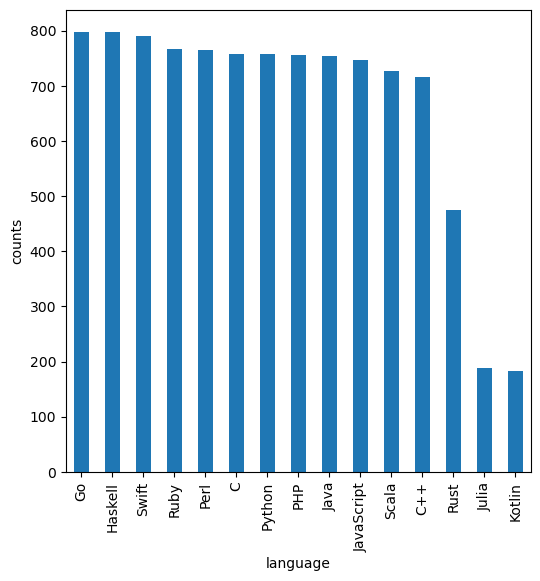

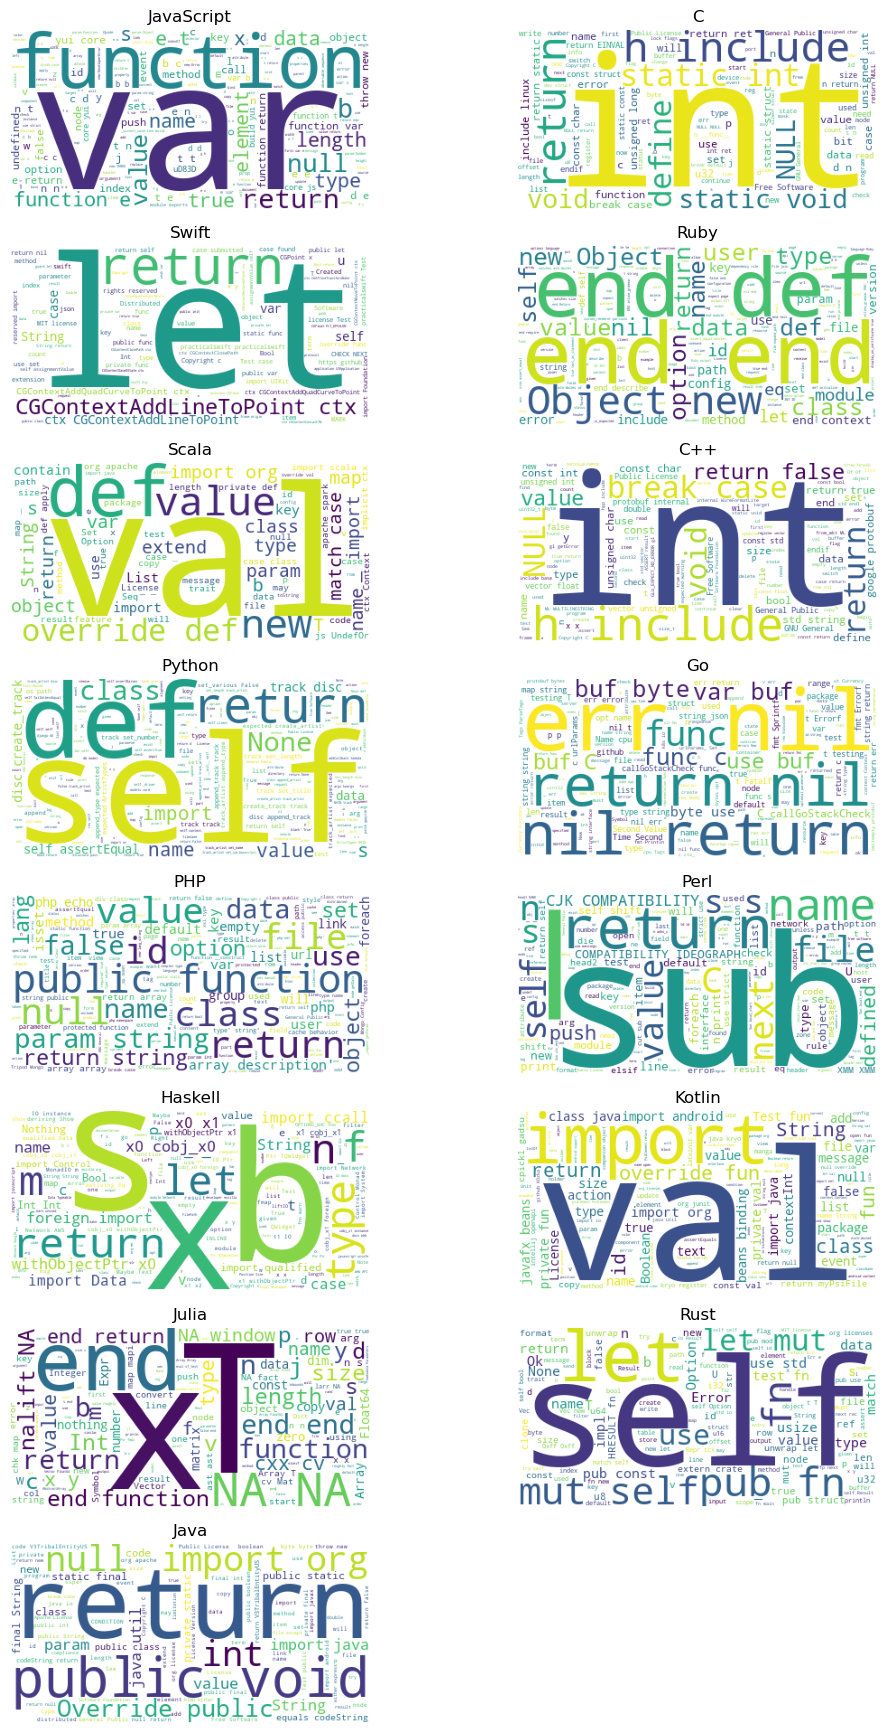

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn import preprocessing
import random

filename = 'data.csv'
p = 0.15  # % of the lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

df = df.dropna().reset_index(drop=True)
df = df.loc[df['language'].isin(['Python', 'Haskell', 'Perl', 'Ruby', 'JavaScript', 'C', 'Go', 'Java', 'Mathematica', 'C++', 'Scala', 'Fortran', 'Kotlin', 'Julia', 'R', 'MATLAB', 'PHP', 'Rust', 'Swift'])].reset_index()

# transforming language name strung to number
le = preprocessing.LabelEncoder()
le.fit(df.language)
df['language_num'] = le.transform(df.language)

df['language'].value_counts().plot.bar(legend='', figsize = (6,6))
plt.ylabel('counts')
#the data is evenly distributed

lang_unique = df['language'].unique()

all_words, languages_dict = {}, {}

#plotting out word clouds to recognise some patterns
fig, ax = plt.subplots(8, 2, sharex=False, figsize = (12,22))
fax = ax.ravel()
for i in range(len(lang_unique)):
    s = ' '.join(df[df['language']==lang_unique[i]]['content'])
    wordcloud = WordCloud(background_color="white",max_words=len(df[df['language']==lang_unique[i]]['content']),max_font_size=200, relative_scaling=0.1).generate(s)
    fax[i].imshow(wordcloud)
    fax[i].set_title(lang_unique[i])
    fax[i].axis("off")
    language_specific_words = {}
    for k, v in wordcloud.words_.items():
        if float(v) > 0.3:
            language_specific_words[k] = v
            languages_dict[str(lang_unique[i])] =language_specific_words
            all_words[k] = 0
#     print(len(language_specific_words)) # how many words appear enough times

import warnings
warnings.filterwarnings('ignore')

#adding columns of features for model
for col in all_words.keys():
    df[col] = 0

fax.flat[-1].set_visible(False)
plt. subplots_adjust() 
plt.show()

In [15]:
# pd.options.mode.chained_assignment = None  # default='warn'

language_weights = pd.DataFrame(languages_dict)

index_to_drop = []

#calculating the word cloud for each individual row is what causes the slow execution of this script
#the dataset should optimally be smaller for this type of solution
#the script was tested out for a 9980 records dataset with 88% accuracy with the word weight threshold of 30% respectively

# for i in range(10): #debug
for i in range(len(df)):
    index_for_match = []
    wordcloud_row = 0
    try:
        a = 0
        wordcloud_row = WordCloud(background_color="white",max_words=len(df['content'][i]),max_font_size=200, relative_scaling=0.1).generate(df['content'][i])
        for a in list(all_words.keys()):
            for b in list(wordcloud_row.words_.keys()):
                if a == b:
                    index_for_match.append(a)
                    
        for j in range(len(index_for_match)):
            df[index_for_match[j]][i] = wordcloud_row.words_[index_for_match[j]]*language_weights.loc[index_for_match[j]][df.language[i]]

    except ValueError:  
                index_to_drop.append(i)

df = df.fillna(0)
df = df.drop(index=index_to_drop)
# df

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = df.language_num
features = ['']
X = df[all_words.keys()]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

rf_model = RandomForestClassifier(random_state = 1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

missed_values = len(rf_val_predictions) - (rf_val_predictions == val_y).sum()
percentage_wrong = missed_values/len(rf_val_predictions)*100

print('The model works well for ' + str(round(100-percentage_wrong)) + '% of cases. \nPredicted ' + str(len(rf_val_predictions)-missed_values) + ' out of ' + str(len(rf_val_predictions)) + ' correctly')


The model works well for 88% of cases. 
Predicted 2195 out of 2495 correctly


In [18]:
actual_values_index = val_y.index.tolist() 
actual_values = val_y.tolist() 

compared_values = df.loc[actual_values_index, ['language','language_num']]
compared_values['rf_predictions'] = rf_val_predictions
compared_values['rf_pred_by_name'] = le.inverse_transform(rf_val_predictions)

print(compared_values.rf_pred_by_name.value_counts())
# print('\nMathematica was responsible for ' +str(801/compared_values.rf_pred_by_name.value_counts().sum()*100) + '% of all errors')

rf_pred_by_name
Ruby          379
Java          189
Go            188
Perl          184
PHP           184
Swift         180
C++           179
Scala         175
JavaScript    167
C             163
Haskell       162
Python        148
Rust          114
Kotlin         46
Julia          37
Name: count, dtype: int64


In [19]:
len(df)

9980